<br></br>
This notebook provides an example of deblending HI gas in galaxy pairs.   

See the accompanied paper for more details: [Huang et al. 2024]()

<br></br>

In [1]:
import numpy as np
from PIL import Image
from astropy.io import fits
import matplotlib.pyplot as plt

### Input files

- cube: HI data cube
- mask: mask cube
- opti: optical image of the same field cut from DESI Legacy Imaging Surveys
- img: RGB image cut from DESI Legacy Imaging Surveys (for visualization only)

If you don't have those DESI images, see the **last cell** of this notebook, or use images from other surveys instead.  

**NOTE:**  
Currently, the code requires that the spaxel size of the data cube is an integral multiple of the pixel size of the optical images.  (Otherwise one should use ```reproject```.)  

For example, the spaxel size of our HI data is 6'', so we downgrade the DESI images to 1''.

In [2]:
name = "WALLABY_J103540-284607"
cube = fits.open("./data/" + name + "_cube.fits")
mask = fits.open("./data/" + name + "_mask.fits")
opti = fits.open("./data/" + name + "_desi.fits")
img = np.flipud(np.array(Image.open("./data/" + name + "_opt.jpg")))
pix = 6   # 6"/1" = 6

# moment-0 map
mom0 = np.nansum(cube[0].data * mask[0].data, axis=0)
masked_mom0 = np.ma.masked_array(mom0, np.abs(mom0)<1e-8)

# shape of the data cube
z, h, w = np.shape(cube[0].data)

# coordinate systems
from astropy.wcs import WCS
wcs = WCS(cube[0].header)[0]
wcs_opt = WCS(opti[0].header)
coords = wcs.pixel_to_world(w/2-0.5, h/2-0.5)

### display the source (opt + HI)

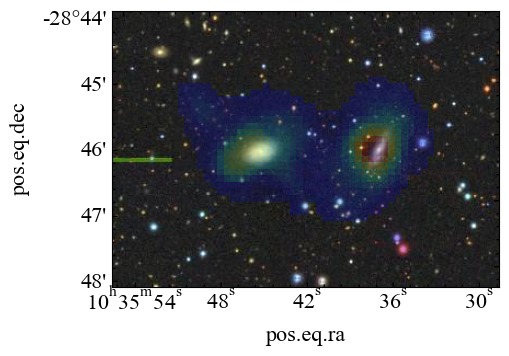

In [3]:
plt.figure(figsize=(5,5))
plt.subplot(111, projection=wcs)
plt.imshow(img, extent=[-.5, w-.5, -.5, h-.5])
plt.imshow(masked_mom0, alpha=0.2, cmap="jet")

### Generate star masks using Gaia DR3 data  

#### Free Parameters
- **mask size**  
    We use circles to mask the stars in optical images. Currently, the radii of these circles should be set by hand. Here we utilize the flux in the Gaia RP-band.
    
- **Gaia star-galaxy separation**  
    We use an empirical criterion based on Gaia colors to skip galaxies in the Gaia catalog while retaining most of the stars: $\rm G - 0.4G_{RP}-0.6G_{BP} > 0.3$. (please use more precise criteria if you know)

In [4]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1

# check your network connections
gaia_table = Gaia.query_object_async(coords, width=w/500*u.deg, height=h/500*u.deg)
star_mask  = np.zeros_like(opti[0].data[0]).astype(np.int8)

for star in gaia_table:
    star_coord = SkyCoord(ra=star["ra"], dec=star["dec"],
                          unit=(u.degree, u.degree), frame='icrs')
    star_pixel = wcs_opt[0].world_to_pixel(star_coord)
    y_pix, x_pix = int(star_pixel[1]), int(star_pixel[0])
    
    # Gaia star-galaxy separation: skip galaxies 
    if star["phot_g_mean_mag"]-0.4*star["phot_rp_mean_mag"]-0.6*star["phot_bp_mean_mag"] > 0.3:
        continue
        
    # mask radius = r
    try: r = int((star["phot_rp_mean_flux"])**0.1) * 3 + 1
    except: r = 2
    
    # add a circle to the mask
    for i in range(y_pix-r, y_pix+r):
        for j in range(x_pix-r, x_pix+r):
            if (j - x_pix)**2 + (i - y_pix)**2 < r**2:
                try: star_mask[i][j] = 1
                except: pass

INFO: Query finished. [astroquery.utils.tap.core]


### source detection on optical images

We use the source detection results on optical images as "priors" for the 3D deblending on HI data cubes. So a significant overlap between optical disks and their corresponding HI detections is required. Otherwise, you may have to set the labels manually.

#### Free Parameters
parameters of [_photutils.segmentation.detect_sources_](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html) and [_photutils.segmentation.deblend_sources_](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html):
   - **detect threshold:** nsigma=3  [pixel]
   - **smooth kernel:** make_2dgaussian_kernel(fwhm=4, size=21) [pixel]
   - nlevels=8, contrast=0.1, npixel=100

Deblending:   0%|          | 0/1 [00:00<?, ?it/s]

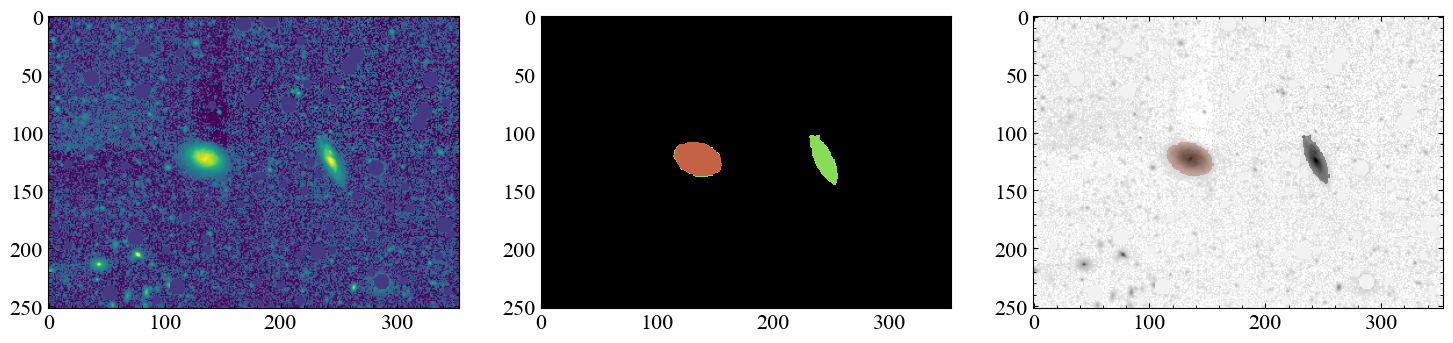

In [5]:
from astropy.convolution import Gaussian1DKernel, convolve
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, make_2dgaussian_kernel

# optical image data
data = np.ma.masked_array(opti[0].data[0],star_mask==1)
data = opti[0].data[0]
data[star_mask==1] = 0

# source detection and deblending using photutils
threshold = detect_threshold(data, nsigma=3)
fwhm = 3
kernel = make_2dgaussian_kernel(fwhm, size=13)

npixels = 300

data_smooth = convolve(data, kernel) # smoothed optical images

segm = detect_sources(data_smooth, threshold, npixels=npixels)
segm_deblend = deblend_sources(data_smooth, segm, npixels=npixels, nlevels=8, contrast=0.1)

# try to reduce the value of npixel if only one source is detected
while np.max(segm_deblend) < 2:
    npixels -= 10
    segm = detect_sources(data_smooth, threshold, npixels=npixels)
    segm_deblend = deblend_sources(data_smooth, segm, npixels=npixels, nlevels=8, contrast=0.1)

# deblending results with background masked
masked_deb = np.ma.masked_array(segm_deblend, np.abs(segm_deblend) < 1e-8)

# show the results
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(np.cbrt(data), vmin=-.1, vmax=.5)
plt.subplot(132)
plt.imshow(segm, cmap=segm.cmap)
plt.subplot(133)
plt.imshow(masked_deb, cmap=segm_deblend.cmap)
plt.imshow(np.cbrt(data), alpha=.7, cmap="Greys", vmin=-.1, vmax=.6)

### deblending of the moment-0 map (2D)

We use the traditional watershed algorithm to deblend galaxy pairs. The results of this 2D method are similar to the 3D methods below when the separation between galaxies is large enough. It also helps to test our code. 

#### Free Parameters
- **find central regions**
   - make_2dgaussian_kernel(fwhm=3,size=15): the kernel to smooth the optical image
   - thresh=0: within each segment of the deblending results above, pixels with [flux > mean + std * thresh] are set as the marker
- **mom0_ext**  
    smooth the moment-0 map or not (in line 28, not important)
- **minimal growth**  
    min_growth = 5*pix^2: we run the watershed algorithm twice. After the first run, markers that grow less than _min_growth_ pixels in area are cleaned, because they are very likely to be contaminant sources. (not important)

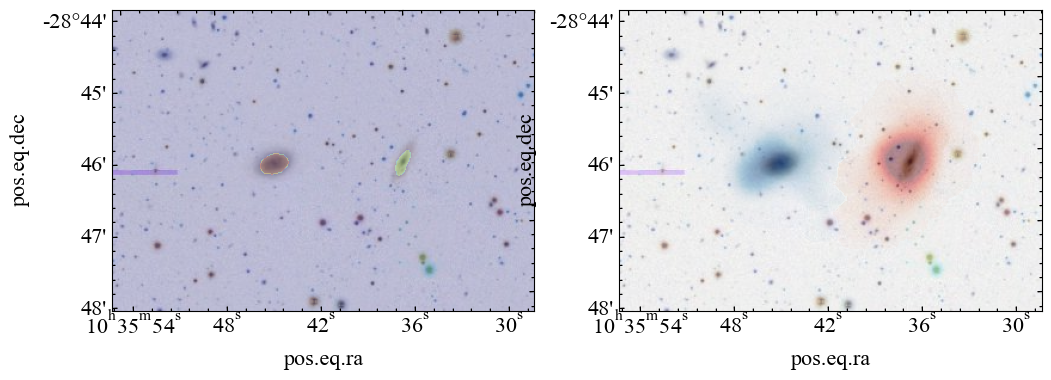

In [6]:
from skimage.segmentation import watershed

def extend(array, num=pix, smooth=False):
    '''enlarge and smooth an image'''
    shape = np.shape(array)
    dim = len(shape)
    if dim == 3: extend_array = np.zeros((shape[0],num*shape[1],num*shape[2]))
    elif dim==2: extend_array = np.zeros((num*shape[0] ,num*shape[1]))
    else: raise("ERROR: Dimension must be 2 or 3.")
    for i in range(shape[-2]):
        for j in range(shape[-1]):
            if dim == 3: 
                for zz in range(shape[0]):
                    extend_array[zz, i*num:(i+1)*num, j*num:(j+1)*num] = array[zz,i,j]
            elif dim==2: 
                extend_array[i*num:(i+1)*num, j*num:(j+1)*num] = array[i][j]
    # 3d smoothing is time-consuming
    if smooth:
        kernel2d = make_2dgaussian_kernel(fwhm=num,size=3*num+1)
        if dim == 2: 
            extend_array = convolve(extend_array, kernel2d)
        elif dim == 3: 
            for freq in range(len(extend_array)):
                extend_array[freq] = convolve(extend_array[freq], kernel2d)
    return extend_array

# Spaxel size of WALLABY data is 6 times that of the DESI images, 
# so we divide each WALLABY spaxel into 6*6 subpixels and smooth them.
mom0_ext = extend(mom0, smooth=True)

# find the central regions of galaxies and set them as markers
markers2d = np.zeros_like(segm)
for i in np.unique(masked_deb):
    if i == 0 or np.ma.is_masked(i): 
        continue
    thresh = 0.
    segment = (masked_deb == i)
    mean, std = np.mean(data_smooth[segment]), np.std(data_smooth[segment])
    markers2d[np.logical_and(data_smooth > mean + std * thresh, segment)] = i

# initial watershed (res: result)
res2d = watershed(-mom0_ext, markers2d, mask=np.abs(mom0_ext)>1e-6, 
                  connectivity=2)

# clean markers that grow less than min_growth pixels
min_growth = 5 * pix**2
for i in np.unique(res2d):
    if i > 0 and np.sum(res2d == i) < np.sum(markers2d == i) + min_growth:
        markers2d[res2d==i] = 0  
        
# rerun watershed
res2d = watershed(-mom0_ext, markers2d, mask=np.abs(mom0_ext)>1e-6,
                  connectivity=2)

# get every segments of the deblend results
segments = []
for i in np.unique(res2d):
    if i > 0:
        segments.append(np.ma.masked_array(mom0_ext, np.abs(res2d-i)>1e-4))

# plot the results
plt.figure(figsize=(12,5))
plt.subplot(121, projection=wcs)
plt.imshow(markers2d, extent=[0,w,0,h], alpha=0.4, cmap="jet")
plt.imshow([255]*3 - img, alpha=0.5, extent=[0,w,0,h])

plt.subplot(122, projection=wcs)
cmaps = ["Reds", "Blues", "Purples", "Greens", "Greys", "Oranges"] * 10
for n, seg in enumerate(segments):
    plt.imshow(seg, cmap=cmaps[n], alpha=0.8, extent=[0,w,0,h])
    plt.clim(0, np.max(masked_mom0)/1.6)   
plt.imshow([255]*3 - img, alpha=0.5, extent=[0,w,0,h])

### 3D deblending

There are two steps to deblend galaxies in a 3D data cube. Both steps apply the watershed algorithm, while their main difference is where the markers are set.

1. **fixed-3D:** in all channels, markers are placed in the same place as the 2D deblending method.
2. **peak-3D:** find 3D peaks in the smoothed data cube, then assign labels to these peaks according to the result of fixed-3D.

Before running _watershed_, we should smooth/bin the data cube to increase S/N.

#### Free Parameters
- **smooth kernel**  
    smooth=4.0: the smoothness of data along the frequency axis. The result will make no sense if this parameter is too large (or too small in some cases).
- **peak finder**  
    We modified the function [_photutils.detection.find_peaks_](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html) to make it applicable to 3D arrays. View the link for details.
- **minimum growth**  (not important)  
    min_growth = z*pix^2: same as that in 2D deblending 

In [7]:
from scripts.find_peaks_3d import find_peaks

cube_ext = extend(cube[0].data, smooth=True)
mask_ext = extend(mask[0].data)

def freq_smooth(cube, bin_size=4, smooth=0):
    '''bin or smooth the data cube along the frequency axis'''
    if not smooth: # bin
        shape = cube.shape
        cube_new = np.zeros((shape[0]//bin_size, shape[1], shape[2]))
        for freq in range(cube.shape[0]//bin_size):
            cube_new[freq] = np.sum(cube[freq*bin_size : (freq+1)*bin_size], axis=0)
    else: # smooth
        cube_new = np.zeros_like(cube)
        kernel = Gaussian1DKernel(smooth)
        for i in range(cube.shape[1]):
            for j in range(cube.shape[2]):
                cube_new[:,i,j] = convolve(cube[:,i,j], kernel)
    return cube_new

# bin / smooth the data
mask_smooth = mask_ext
cube_smooth = freq_smooth(cube_ext, smooth=4.0)

markers3d = np.zeros_like(cube_smooth).astype(np.int8)

## Step 1: fixed-3D ##
for freq in range(len(cube_smooth)):
    markers3d[freq] = markers2d

res3d0 = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-6,
                   connectivity=2)

# clean markers that grow less than min_growth pixels in area
min_growth = pix**2 * z
for i in np.unique(res3d0):
    if i > 0 and np.sum(res3d0 == i) < np.sum(markers3d == i) + min_growth:
        markers3d[res3d0==i] = 0

res3d0 = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-6,
                   connectivity=2)
    
## Step 2: peak-3D ##
threshold = np.zeros_like(cube_smooth) + np.nanstd(cube_smooth) * 3
peaks = find_peaks(cube_smooth * mask_smooth, threshold, box_size=10, npeaks=10)

markers3d[:] = 0  # reset markers
for peak in peaks:
    i,j,k = peak["z_peak"], peak["y_peak"], peak["x_peak"]
    # place markers in the vicinity of the flux peaks
    markers3d[i-3:i+3,j-2:j+2,k-2:k+2] = res3d0[i-3:i+3,j-2:j+2,k-2:k+2]
        
res3d = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-8)

# running this cell may take a long time for large data cubes

Now we have three deblending results (2D: _res2d_, fixed-3D: _red3d0_, peak-3D: _res3d_) with increasing reliability.  
The **peak-3D** result is preferred when it's available.  
These results can be used to derive other properties of galaxies.  
<br></br><br></br><br></br>

### visualization  
Here are some simple ways to take a glance at the deblending results.

#### channel map

In [8]:
from ipywidgets import interact

@interact(channel=(0, -1+len(cube_smooth)))
def plot_cube(channel):
    plt.figure(figsize=(12,6))

    plt.subplot(121, projection=wcs)
    plt.imshow((cube_smooth * mask_smooth)[channel], cmap="gray", extent=[0,w,0,h])
    plt.imshow(np.ma.masked_array(markers3d[channel],markers3d[channel]==0),
               cmap="autumn", extent=[0,w,0,h])

    plt.subplot(122, projection=wcs)
    plt.imshow(res3d[channel], cmap="jet", extent=[0,w,0,h])
    plt.clim(0, np.max(res3d)+1)
    plt.imshow([255] * 3 - img, alpha=0.7, extent=[0,w,0,h])
    plt.scatter(peaks["x_peak"]/pix, peaks["y_peak"]/pix, c="r", s=10)
    plt.legend(("HI peaks",))

interactive(children=(IntSlider(value=53, description='channel', max=107), Output()), _dom_classes=('widget-in…

#### deblended moment-0 maps

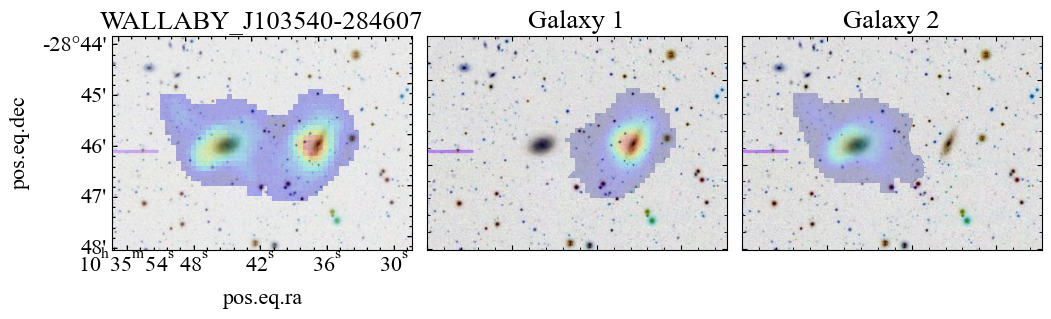

In [9]:
segments3d = []
for i in np.unique(res3d):
    if i > 0:
        segments3d.append(np.ma.masked_array(cube_smooth, np.abs(res3d-i)>0.1))
L = len(segments3d) + 1

plt.figure(figsize=(L * 4, 4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, L, 1, projection=wcs)
plt.imshow(masked_mom0, alpha=0.9, cmap="jet")
plt.imshow([255] * 3 - img, alpha=0.7, extent=[0,w,0,h])
plt.title(name)
plt.clim(0, np.max(masked_mom0))

for n, seg3d in enumerate(segments3d):
    plt.subplot(1, L, n+2)
    plt.title("Galaxy " + str(n+1))
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow([255] * 3 - img)
    plt.imshow(np.nansum(seg3d, axis=0), cmap="jet", alpha=0.25, origin="lower")
    plt.clim(0, np.max(masked_mom0))

#### different projections of the cube

/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_58541/2652580108.py:15: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.nansum(res3d, axis=0) / np.nansum(res3d > 0, axis=0), cmap="jet")
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_58541/2652580108.py:18: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(np.nansum(res3d, axis=1) / np.nansum(res3d > 0, axis=1), cmap="jet")
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_58541/2652580108.py:21: RuntimeWarning: invalid value encountered in divide
  plt.pcolor((np.nansum(res3d, axis=2) / np.nansum(res3d > 0, axis=2)).T, cmap="jet")
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_58541/2652580108.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


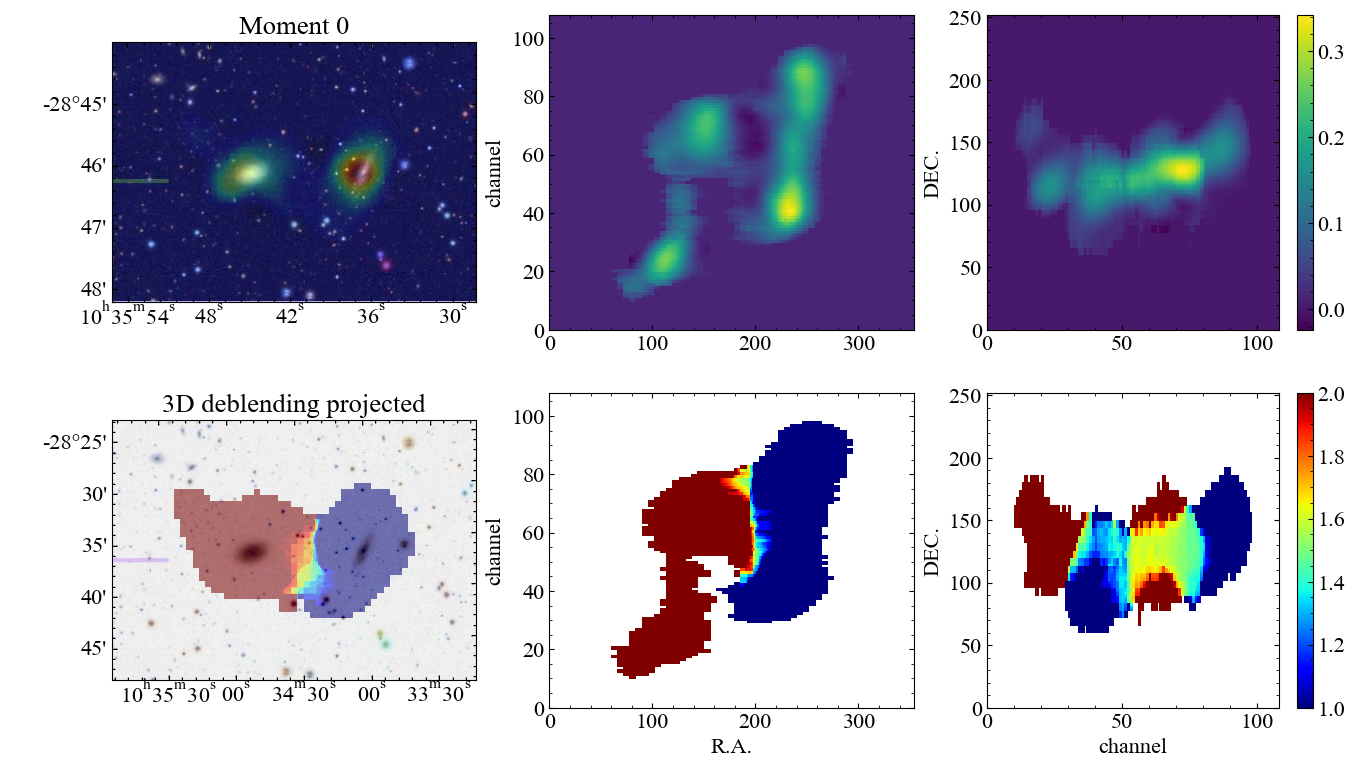

In [10]:
plt.figure(figsize=(16,9))
plt.subplot(231, projection=wcs_opt[0])
plt.imshow(img, extent=[0,w*pix,0,h*pix])
plt.imshow(np.nansum(mask_smooth * cube_smooth, axis=0), cmap="jet", alpha=0.3)
plt.title("Moment 0"); plt.xlabel(" "); plt.ylabel(" ")
plt.subplot(232)
plt.pcolor(np.nansum(mask_smooth * cube_smooth, axis=1))
plt.ylabel("channel")
plt.subplot(233)
plt.pcolor(np.nansum(mask_smooth * cube_smooth, axis=2).T)
plt.colorbar()
plt.ylabel("DEC.")
plt.subplot(234, projection=wcs)
plt.title("3D deblending projected"); plt.xlabel(" "); plt.ylabel(" ")
plt.imshow(np.nansum(res3d, axis=0) / np.nansum(res3d > 0, axis=0), cmap="jet")
plt.imshow([255] * 3 - img, alpha=.5, extent=[0,w*pix,0,h*pix])
plt.subplot(235)
plt.pcolor(np.nansum(res3d, axis=1) / np.nansum(res3d > 0, axis=1), cmap="jet")
plt.xlabel("R.A."); plt.ylabel("channel")
plt.subplot(236)
plt.pcolor((np.nansum(res3d, axis=2) / np.nansum(res3d > 0, axis=2)).T, cmap="jet")
plt.ylabel("DEC."); plt.xlabel("channel")
plt.colorbar()

<br></br>
#### Get DESI images from https://www.legacysurvey.org/viewer

In [22]:
cube = cube        # input data cube
path = "./data"    # path to save the images
layer = "ls-dr10"  # other choices: ls-dr9, sdss, hsc-dr2, unwise-neo7, galex, ...
pixel_scale = 1.0  # in arcsec

# Important: Now the code requires that the spaxel size of the data
#            cube is an **integer multiple** of this pixel_scale. 
# For example, the spaxel size of WALLABY data is 6'', 
# so we use DESI images with pixel_scale = 1''.

pix = round(cube[0].header["CDELT2"] / pixel_scale * 3600)  # pix = 6''/1'' = 6

wcs = WCS(cube[0].header)[0]
z, h, w = np.shape(cube[0].data)   # shape of the data cube
coords = wcs.pixel_to_world(w/2-0.5, h/2-0.5)
ra, dec = coords.ra.value, coords.dec.value

# .fits cutout
url_fits = "https://www.legacysurvey.org/viewer/cutout.fits?ra="+str(ra)+"&dec="+str(dec)+"&layer="+layer+"&pixscale="+str(pixel_scale)+"&width="+str(w*pix)+"&height="+str(h*pix)
hdul = fits.open(url_fits)
hdul.writeto(path + "/desi.fits", overwrite=True)

# .jpg cutout
import requests
from io import BytesIO

url_jpg = "https://www.legacysurvey.org/viewer/cutout.jpg?ra="+str(ra)+"&dec="+str(dec)+"&layer="+layer+"&pixscale="+str(pixel_scale)+"&width="+str(w*pix)+"&height="+str(h*pix)
response = requests.get(url_jpg)
Image.open(BytesIO(response.content)).save("./data/desi.jpg", overwrite=True)